# Train an neural network for regression

- Watch this video https://lightning.ai/docs/pytorch/stable/starter/introduction.html

In [1]:
# pip install lightning pandas matplotlib

In [2]:
# Replace this test data with your data

import pandas as pd
df = pd.read_json(
    "https://raw.githubusercontent.com/kuennethgroup/colab_tutorials/main/lecture2/data/polymers_tend_to_crystalize.json"
)
df

,smiles,property,value,fingerprint
0,[*]C[*],Xc,47.80,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,[*]CC([*])C,Xc,44.47,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,[*]CC([*])CC,Xc,34.04,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,[*]CC([*])CCC,Xc,20.01,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,[*]CC([*])CC(C)C,Xc,21.64,"[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
427,[*]C([*])(F)F,Xc,31.84,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
428,[*]C/C=C\C[*],Xc,25.58,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
429,[*]O[Si](C)(C)CCCC(=O)Oc1ccc(C=Nc2ccc(N=Cc3ccc...,Xc,29.05,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
430,[*]O[Si](C)(C)CCCC(=O)Oc1ccc(C=Nc2ccc(Cc3ccc(N...,Xc,21.74,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


In [19]:
import torch, torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import lightning as L

# --------------------------------
# Define a LightningModule by subclassing LightningModule
# A LightningModule is a subclass of nn.Module


class LitRegressor(L.LightningModule):
    def __init__(self):
        # -- Define your NN
        super().__init__()
        input_size = 2048
        self.l1 = nn.Sequential(nn.Linear(input_size, 300), nn.ReLU(), nn.Dropout(0.4))
        self.l2 = nn.Sequential(nn.Linear(300, 100), nn.ReLU(), nn.Dropout(0.4))
        self.l3 = nn.Sequential(nn.Linear(100, 1))

    def forward(self, x):
        # -- Define how to ho forward through your NN
        # forward defines the prediction/inference actions
        x = self.l3(self.l2(self.l1(x)))
        return x

    def training_step(self, batch, batch_idx):
        # -- Define how to do a training step
        # Split to input and output as you defined it in your dataloader
        x, y = batch
        # fog forward and get prediction 
        x = self.forward(x)
        # compute loss
        y = y.view(x.size(0), -1)
        loss = F.mse_loss(y, x)
        # log the loss (for plotting later)
        self.log("train_loss", loss, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        # -- Define how to do a validation step (similar to raining)
        x, y = batch
        x = self.forward(x)
        y = y.view(x.size(0), -1)
        loss = F.mse_loss(x, y)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        # Define the optimize that you want to use
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

## Load data

In [4]:
import torch.utils.data as data_utils
import numpy as np
from sklearn.model_selection import train_test_split

# split
train, val = train_test_split(df, shuffle=True, random_state=123)

# Train
train_fps = torch.Tensor(np.stack(train["fingerprint"].values).astype(np.float32))
train_values = torch.Tensor(np.stack(train["value"].values).astype(np.float32))
train_data = data_utils.TensorDataset(train_fps, train_values)
train_loader = data_utils.DataLoader(train_data, batch_size=30, shuffle=False)

# Validation
val_fps = torch.Tensor(np.stack(val["fingerprint"].values).astype(np.float32))
val_values = torch.Tensor(np.stack(val["value"].values).astype(np.float32))
val_data = data_utils.TensorDataset(val_fps, val_values)
val_loader = data_utils.DataLoader(val_data, batch_size=30, shuffle=False)

# Test
# test loader, we use the same dataset as for val (for now); no values here
test_fps = torch.Tensor(np.stack(val["fingerprint"].values).astype(np.float32))
test_values = torch.Tensor(np.stack(val["value"].values).astype(np.float32))
test_loader = data_utils.DataLoader(test_fps, batch_size=30, shuffle=False)

# Train

In [20]:
from lightning.pytorch.callbacks import ModelSummary
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint

from pathlib import Path
import shutil


save_dir = Path("my_model")
if save_dir.exists():
    shutil.rmtree(save_dir)

callbacks = [
    ModelCheckpoint(dirpath=save_dir, save_top_k=1, monitor="val_loss", verbose=True),
    ModelSummary(max_depth=-1),
    EarlyStopping(monitor="val_loss", mode="min", verbose=True),
]


regressor = LitRegressor()
trainer = L.Trainer(
    max_epochs=50,
    log_every_n_steps=1,
    val_check_interval=1,
    callbacks=callbacks,
)
trainer.fit(model=regressor, train_dataloaders=train_loader, val_dataloaders=val_loader)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type       | Params
------------------------------------
0 | l1   | Sequential | 614 K 
1 | l1.0 | Linear     | 614 K 
2 | l1.1 | ReLU       | 0     
3 | l1.2 | Dropout    | 0     
4 | l2   | Sequential | 30.1 K
5 | l2.0 | Linear     | 30.1 K

/home/chris/courses/colab_tutorials/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=191` in the `DataLoader` to improve performance.
/home/chris/courses/colab_tutorials/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=191` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 11/11 [00:00<00:00, 30.06it/s, v_num=1, train_loss=2.27e+3, val_loss=1.86e+3]

Metric val_loss improved. New best score: 1856.560
Epoch 0, global step 11: 'val_loss' reached 1856.55957 (best 1856.55957), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=0-step=11.ckpt' as top 1


Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 60.30it/s, v_num=1, train_loss=1.64e+3, val_loss=1.29e+3]

Metric val_loss improved by 565.224 >= min_delta = 0.0. New best score: 1291.336
Epoch 1, global step 22: 'val_loss' reached 1291.33594 (best 1291.33594), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=1-step=22.ckpt' as top 1


Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 63.90it/s, v_num=1, train_loss=1.13e+3, val_loss=1.17e+3]

Metric val_loss improved by 125.464 >= min_delta = 0.0. New best score: 1165.872
Epoch 2, global step 33: 'val_loss' reached 1165.87158 (best 1165.87158), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=2-step=33.ckpt' as top 1


Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 63.88it/s, v_num=1, train_loss=1.1e+3, val_loss=1.05e+3] 

Metric val_loss improved by 119.236 >= min_delta = 0.0. New best score: 1046.635
Epoch 3, global step 44: 'val_loss' reached 1046.63550 (best 1046.63550), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=3-step=44.ckpt' as top 1


Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 61.26it/s, v_num=1, train_loss=944.0, val_loss=942.0]   

Metric val_loss improved by 104.702 >= min_delta = 0.0. New best score: 941.934
Epoch 4, global step 55: 'val_loss' reached 941.93372 (best 941.93372), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=4-step=55.ckpt' as top 1


Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 65.64it/s, v_num=1, train_loss=731.0, val_loss=833.0] 

Metric val_loss improved by 109.245 >= min_delta = 0.0. New best score: 832.688
Epoch 5, global step 66: 'val_loss' reached 832.68829 (best 832.68829), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=5-step=66.ckpt' as top 1


Epoch 6: 100%|██████████| 11/11 [00:00<00:00, 63.66it/s, v_num=1, train_loss=483.0, val_loss=729.0]

Metric val_loss improved by 103.391 >= min_delta = 0.0. New best score: 729.297
Epoch 6, global step 77: 'val_loss' reached 729.29724 (best 729.29724), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=6-step=77.ckpt' as top 1


Epoch 7: 100%|██████████| 11/11 [00:00<00:00, 64.62it/s, v_num=1, train_loss=359.0, val_loss=644.0]

Metric val_loss improved by 85.583 >= min_delta = 0.0. New best score: 643.715
Epoch 7, global step 88: 'val_loss' reached 643.71454 (best 643.71454), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=7-step=88.ckpt' as top 1


Epoch 8: 100%|██████████| 11/11 [00:00<00:00, 63.53it/s, v_num=1, train_loss=341.0, val_loss=576.0]

Metric val_loss improved by 67.377 >= min_delta = 0.0. New best score: 576.337
Epoch 8, global step 99: 'val_loss' reached 576.33746 (best 576.33746), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=8-step=99.ckpt' as top 1


Epoch 9: 100%|██████████| 11/11 [00:00<00:00, 63.72it/s, v_num=1, train_loss=244.0, val_loss=523.0]

Metric val_loss improved by 53.286 >= min_delta = 0.0. New best score: 523.051
Epoch 9, global step 110: 'val_loss' reached 523.05121 (best 523.05121), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=9-step=110.ckpt' as top 1


Epoch 10: 100%|██████████| 11/11 [00:00<00:00, 66.31it/s, v_num=1, train_loss=149.0, val_loss=480.0]

Metric val_loss improved by 43.317 >= min_delta = 0.0. New best score: 479.734
Epoch 10, global step 121: 'val_loss' reached 479.73444 (best 479.73444), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=10-step=121.ckpt' as top 1


Epoch 11: 100%|██████████| 11/11 [00:00<00:00, 65.59it/s, v_num=1, train_loss=109.0, val_loss=446.0]

Metric val_loss improved by 34.059 >= min_delta = 0.0. New best score: 445.675
Epoch 11, global step 132: 'val_loss' reached 445.67520 (best 445.67520), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=11-step=132.ckpt' as top 1


Epoch 12: 100%|██████████| 11/11 [00:00<00:00, 66.15it/s, v_num=1, train_loss=127.0, val_loss=431.0]

Metric val_loss improved by 14.924 >= min_delta = 0.0. New best score: 430.751
Epoch 12, global step 143: 'val_loss' reached 430.75137 (best 430.75137), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=12-step=143.ckpt' as top 1


Epoch 13: 100%|██████████| 11/11 [00:00<00:00, 66.07it/s, v_num=1, train_loss=128.0, val_loss=419.0]

Metric val_loss improved by 11.476 >= min_delta = 0.0. New best score: 419.276
Epoch 13, global step 154: 'val_loss' reached 419.27582 (best 419.27582), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=13-step=154.ckpt' as top 1


Epoch 14: 100%|██████████| 11/11 [00:00<00:00, 64.54it/s, v_num=1, train_loss=111.0, val_loss=395.0]

Metric val_loss improved by 24.733 >= min_delta = 0.0. New best score: 394.542
Epoch 14, global step 165: 'val_loss' reached 394.54239 (best 394.54239), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=14-step=165.ckpt' as top 1


Epoch 15: 100%|██████████| 11/11 [00:00<00:00, 64.05it/s, v_num=1, train_loss=129.0, val_loss=389.0]

Metric val_loss improved by 5.969 >= min_delta = 0.0. New best score: 388.573
Epoch 15, global step 176: 'val_loss' reached 388.57330 (best 388.57330), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=15-step=176.ckpt' as top 1


Epoch 16: 100%|██████████| 11/11 [00:00<00:00, 62.25it/s, v_num=1, train_loss=98.80, val_loss=387.0]

Metric val_loss improved by 1.647 >= min_delta = 0.0. New best score: 386.927
Epoch 16, global step 187: 'val_loss' reached 386.92654 (best 386.92654), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=16-step=187.ckpt' as top 1


Epoch 17: 100%|██████████| 11/11 [00:00<00:00, 64.69it/s, v_num=1, train_loss=71.00, val_loss=362.0]

Metric val_loss improved by 25.192 >= min_delta = 0.0. New best score: 361.735
Epoch 17, global step 198: 'val_loss' reached 361.73489 (best 361.73489), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=17-step=198.ckpt' as top 1


Epoch 18: 100%|██████████| 11/11 [00:00<00:00, 63.03it/s, v_num=1, train_loss=110.0, val_loss=356.0]

Metric val_loss improved by 5.440 >= min_delta = 0.0. New best score: 356.295
Epoch 18, global step 209: 'val_loss' reached 356.29492 (best 356.29492), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=18-step=209.ckpt' as top 1


Epoch 19: 100%|██████████| 11/11 [00:00<00:00, 64.05it/s, v_num=1, train_loss=82.30, val_loss=346.0]

Metric val_loss improved by 10.199 >= min_delta = 0.0. New best score: 346.096
Epoch 19, global step 220: 'val_loss' reached 346.09589 (best 346.09589), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=19-step=220.ckpt' as top 1


Epoch 20: 100%|██████████| 11/11 [00:00<00:00, 64.01it/s, v_num=1, train_loss=168.0, val_loss=343.0]

Metric val_loss improved by 2.817 >= min_delta = 0.0. New best score: 343.279
Epoch 20, global step 231: 'val_loss' reached 343.27875 (best 343.27875), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=20-step=231.ckpt' as top 1


Epoch 21: 100%|██████████| 11/11 [00:00<00:00, 64.10it/s, v_num=1, train_loss=136.0, val_loss=350.0]

Epoch 21, global step 242: 'val_loss' was not in top 1


Epoch 22: 100%|██████████| 11/11 [00:00<00:00, 66.20it/s, v_num=1, train_loss=137.0, val_loss=340.0]

Metric val_loss improved by 3.057 >= min_delta = 0.0. New best score: 340.222
Epoch 22, global step 253: 'val_loss' reached 340.22205 (best 340.22205), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=22-step=253.ckpt' as top 1


Epoch 23: 100%|██████████| 11/11 [00:00<00:00, 66.00it/s, v_num=1, train_loss=93.90, val_loss=352.0]

Epoch 23, global step 264: 'val_loss' was not in top 1


Epoch 24: 100%|██████████| 11/11 [00:00<00:00, 66.49it/s, v_num=1, train_loss=123.0, val_loss=342.0]

Epoch 24, global step 275: 'val_loss' was not in top 1


Epoch 25: 100%|██████████| 11/11 [00:00<00:00, 65.54it/s, v_num=1, train_loss=194.0, val_loss=337.0]

Metric val_loss improved by 2.761 >= min_delta = 0.0. New best score: 337.461
Epoch 25, global step 286: 'val_loss' reached 337.46082 (best 337.46082), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=25-step=286.ckpt' as top 1


Epoch 26: 100%|██████████| 11/11 [00:00<00:00, 65.75it/s, v_num=1, train_loss=114.0, val_loss=333.0]

Metric val_loss improved by 4.027 >= min_delta = 0.0. New best score: 333.434
Epoch 26, global step 297: 'val_loss' reached 333.43387 (best 333.43387), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=26-step=297.ckpt' as top 1


Epoch 27: 100%|██████████| 11/11 [00:00<00:00, 64.05it/s, v_num=1, train_loss=83.20, val_loss=327.0]

Metric val_loss improved by 6.357 >= min_delta = 0.0. New best score: 327.076
Epoch 27, global step 308: 'val_loss' reached 327.07642 (best 327.07642), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=27-step=308.ckpt' as top 1


Epoch 28: 100%|██████████| 11/11 [00:00<00:00, 64.19it/s, v_num=1, train_loss=65.50, val_loss=329.0]

Epoch 28, global step 319: 'val_loss' was not in top 1


Epoch 29: 100%|██████████| 11/11 [00:00<00:00, 62.26it/s, v_num=1, train_loss=81.10, val_loss=331.0]

Epoch 29, global step 330: 'val_loss' was not in top 1


Epoch 30: 100%|██████████| 11/11 [00:00<00:00, 63.88it/s, v_num=1, train_loss=119.0, val_loss=315.0]

Metric val_loss improved by 12.505 >= min_delta = 0.0. New best score: 314.571
Epoch 30, global step 341: 'val_loss' reached 314.57117 (best 314.57117), saving model to '/home/chris/courses/colab_tutorials/lecture_hackathon2/my_model/epoch=30-step=341.ckpt' as top 1


Epoch 31: 100%|██████████| 11/11 [00:00<00:00, 64.40it/s, v_num=1, train_loss=89.20, val_loss=337.0]

Epoch 31, global step 352: 'val_loss' was not in top 1


Epoch 32: 100%|██████████| 11/11 [00:00<00:00, 64.84it/s, v_num=1, train_loss=66.60, val_loss=335.0]

Epoch 32, global step 363: 'val_loss' was not in top 1


Epoch 33: 100%|██████████| 11/11 [00:00<00:00, 64.67it/s, v_num=1, train_loss=64.80, val_loss=340.0]

Monitored metric val_loss did not improve in the last 3 records. Best score: 314.571. Signaling Trainer to stop.
Epoch 33, global step 374: 'val_loss' was not in top 1


Epoch 33: 100%|██████████| 11/11 [00:00<00:00, 64.10it/s, v_num=1, train_loss=64.80, val_loss=340.0]



## Plot

<Axes: xlabel='epoch,step'>

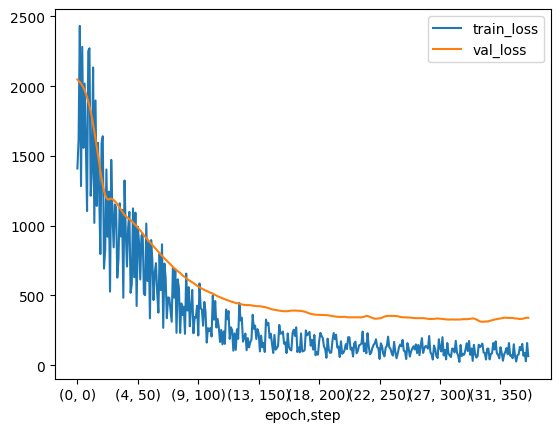

In [35]:
df_res = pd.read_csv(Path(trainer.logger.log_dir) / "metrics.csv")
df_res = df_res.set_index(["epoch", "step"])
df_res = pd.concat([df_res["train_loss"].dropna(), df_res["val_loss"].dropna()], axis=1)
df_res.plot()

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/chris/courses/colab_tutorials/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=191` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 927.43it/s] 
rmse = 17.736155 [%]
r2 = 0.14252982302192596


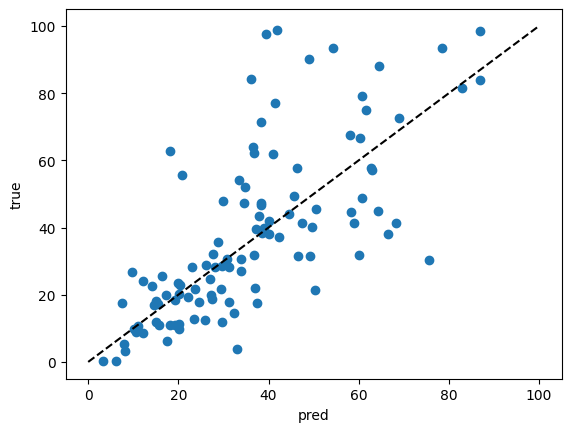

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, r2_score

fig, ax = plt.subplots()
best_regressor = LitRegressor.load_from_checkpoint(list(save_dir.glob("*.ckpt"))[0])

trainer = L.Trainer()
preds = trainer.predict(best_regressor, test_loader)
preds = torch.cat(preds).squeeze().numpy()

rmse = root_mean_squared_error(preds, test_values)
r2 = r2_score(preds, test_values)

ax.plot(preds, test_values, "o")
ax.plot([0, 100], [0, 100], "k--")
ax.set_ylabel("true")
ax.set_xlabel("pred")
print(f"{rmse = } [%]")
print(f"{r2 = }")